In [1]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
import emcee
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import hast
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
import probfit

In [2]:
def abg_profile(x,p_s,r_s,al,be,ga):
    power =  (be - ga) / (al+1e-14)
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return p_s / denominator

In [3]:
path = "/data/POL/HALOA/output_01274"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",comov=True,getcen=False)

loading Dark matter..
is valid  True
loading Gas..
loading Stars..


In [7]:
print myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max()
print myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max()
print myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max()

-2923.93147962 1955.07437975
-9799.78498799 10114.8058251
-9722.03538435 10037.0323876


In [5]:
#centro_com_dm = nbe.real_center(myhalo.dm.pos3d,myhalo.dm.mass)
#print centro_com_dm

In [6]:
#offset = np.sqrt(centro_com_dm[0]**2+centro_com_dm[1]**2+centro_com_dm[2]**2)
#print offset

In [5]:
#ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
#centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
#print "density",centro
############
po, ma = np.copy(myhalo.st.pos3d), np.copy(myhalo.st.mass)
centro_com = nbe.real_center(po,ma,n=7000)
#myhalo.center_shift(centro)
print "centro COM ",centro_com
#print "centro dens",centro_rho

centro COM  [ 9896.89131427  9799.82698744  9776.27473061]


In [8]:
#vector = centro_com - centro_rho
#print np.sqrt((vector[0])**2+(vector[1])**2+(vector[2])**2)

# Centering and generating data


In [6]:
#centro_com = np.array([9896.96445182, 9799.82947537, 9776.26807775])
#centro_com = np.array([-1.64521174, -0.1218235,   0.52621438])

myhalo.st.pos3d = myhalo.st.pos3d - centro_com
myhalo.dm.pos3d = myhalo.dm.pos3d - centro_com
myhalo.gs.pos3d = myhalo.gs.pos3d - centro_com

myhalo.st.r = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
myhalo.dm.r = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2)+(myhalo.dm.pos3d[:,2]**2))
myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))


In [8]:
myhalo.dm.mass = myhalo.dm.mass[np.where(myhalo.dm.r<300.)]
myhalo.dm.pos3d = myhalo.dm.pos3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.vel3d = myhalo.dm.vel3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.r = myhalo.dm.r[np.where(myhalo.dm.r<300)]

myhalo.st.mass = myhalo.st.mass[np.where(myhalo.st.r<300.)]
myhalo.st.pos3d = myhalo.st.pos3d[np.where(myhalo.st.r<300.)]
myhalo.st.r = myhalo.st.r[np.where(myhalo.st.r<300)]

myhalo.gs.mass = myhalo.gs.mass[np.where(myhalo.gs.r<300.)]
myhalo.gs.pos3d = myhalo.gs.pos3d[np.where(myhalo.gs.r<300.)]
myhalo.gs.r = myhalo.gs.r[np.where(myhalo.gs.r<300)]
myhalo.gs.rho = myhalo.gs.rho[np.where(myhalo.gs.r<300)]
myhalo.gs.hsml = myhalo.gs.hsml[np.where(myhalo.gs.r<300)]

In [9]:
average = np.array([np.mean(myhalo.dm.vel3d[:,0]),
                    np.mean(myhalo.dm.vel3d[:,1]),
                    np.mean(myhalo.dm.vel3d[:,2])
                   ])
print "average = ", average


myhalo.dm.vel3d = myhalo.dm.vel3d - average

average =  [ -14.29502296  -63.37027359 -103.3580246 ]


In [10]:
myhalo.dm.R = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2))
myhalo.dm.vr = (myhalo.dm.vel3d[:,0]*myhalo.dm.pos3d[:,0] + \
                myhalo.dm.vel3d[:,1]*myhalo.dm.pos3d[:,1] + \
                myhalo.dm.vel3d[:,2]*myhalo.dm.pos3d[:,2])/ myhalo.dm.r

myhalo.dm.vphi = (-myhalo.dm.vel3d[:,0]*myhalo.dm.pos3d[:,1] +\
                   myhalo.dm.vel3d[:,1]*myhalo.dm.pos3d[:,0] )/ myhalo.dm.R 



In [11]:
print "stars       x_min = {0}, x_max = {1} ".format(myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max())
print "dark matter x_min = {0}, x_max = {1} ".format(myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max())
print "gas         x_min = {0}, x_max = {1} ".format(myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max())

stars       x_min = -282.726401499, x_max = 289.516762563 
dark matter x_min = -299.751792124, x_max = 299.537270376 
gas         x_min = -297.096518687, x_max = 296.064614126 


In [12]:
print len(myhalo.dm.pos3d)
print len(myhalo.st.pos3d)
print len(myhalo.gs.pos3d)

7143533
5946312
9822723


# Getting densities

In [13]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

In [14]:
ok,rho_st,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)

In [15]:
center_dens_st = myhalo.st.pos3d[np.where(rho_st == rho_st.max())]
print center_dens_st

[[-0.12471271 -0.03304212 -0.28254311]]


In [16]:
pos_dens_dm = myhalo.dm.pos3d - center_dens_st[0]
r_cd = np.sqrt((pos_dens_dm[:,0]**2)+(pos_dens_dm[:,1]**2)+(pos_dens_dm[:,2]**2))

In [17]:
R_hsml = myhalo.gs.hsml.min()
print R_hsml

0.15194


# DM profile and fit

In [20]:
#centroide = nbe.real_ce(myhalo.dm.pos3d,myhalo.dm.mass)
#print centro_dm
#myhalo.center_shift(centro_dm)
#myhalo.redefine(2)
#print myhalo.dm.pos3d[np.where(rho_dm == rho_dm.max())]
#################################
Pcrit = myhalo.dm._p.rho_crit
Mdm = myhalo.dm.mass.min()
myradiuses = myhalo.dm.r[np.argsort(myhalo.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
#R_hsml = myhalo.gs.hsml()
##################################
r_p = np.logspace(np.log10(1.5),np.log10(300),200)
#r_p = np.linspace(1,300,300)

#r_p = np.concatenate((np.logspace(np.log10(R_hsml),np.log10(3.),10),
#                     np.linspace(3.9,300,100)))
dens = np.array([])
dens_cd = np.array([])
mean = np.array([])
mean_cd = np.array([])
std = np.array([])
n=np.array([])
m_200=0
m_8 = 0
for i in range(len(r_p)-1):
    shell_cd = np.where((r_cd > r_p[i])&(r_cd < r_p[i+1])&(r_cd > R_hsml))
    shell = np.where((myhalo.dm.r > r_p[i])&(myhalo.dm.r < r_p[i+1])&(myhalo.dm.r > R_hsml))
    n = np.append(n,len(shell[0]))
    mass_cd = np.sum(myhalo.dm.mass[shell_cd])
    mass = np.sum(myhalo.dm.mass[shell])
    if r_p[i]<260.:
        m_200 += mass
    if r_p[i] < 8:
        m_8 += mass
    mean_cd = np.append(mean_cd,np.mean(rho_dm[shell_cd]))
    mean = np.append(mean,np.mean(rho_dm[shell]))
    std = np.append(std,np.std(rho_dm[shell]))
    volume = 4.* np.pi * ((r_p[i+1]**3)-(r_p[i]**3)) / 3.
    dens_cd = np.append(dens,mass_cd/volume)
    dens = np.append(dens,mass/volume)
dens_dm = dens
dens_dm_cd = dens_cd


In [21]:
#def abg_profile(x,p_s,r_s,al,be,ga):
#    power =  (be - ga) / (al)
#    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
#    return p_s / denominator

# Minuit Fit

In [22]:
def abg_logprofile(x,p_s,r_s,al,be,ga):
    x = 10**x
    power =  (be - ga) / (al)
    denominator = ((x/(r_s))**ga) * ((1 + (x / (r_s))**al)**power)
    return np.log10(p_s / denominator)

In [24]:
chi2log = probfit.Chi2Regression(abg_logprofile, np.log10(r_p[0:-1]), np.log10(dens_dm))
iminuit.describe(chi2log)

mi = iminuit.Minuit(chi2log,
                   p_s=0.9e7, limit_p_s=(1e7,1e10), error_p_s=.1,
                   r_s=4.,    limit_r_s=(3,6),error_r_s=0.0001,
                   al=1.5,    limit_al=(0.5,5),error_al=0.0001,
                   be=2,      limit_be=(1,8),error_be=0.0001,
                   ga=0,      limit_ga=(0,4)
                   )
my_fitarg = mi.fitarg
print my_fitarg

{u'error_p_s': 0.1, 'be': 2, u'fix_al': False, u'limit_al': (0.5, 5), u'error_r_s': 0.0001, u'error_be': 0.0001, u'limit_r_s': (3, 6), u'fix_be': False, u'error_al': 0.0001, 'r_s': 4.0, u'fix_ga': False, 'al': 1.5, u'error_ga': 1.0, u'limit_ga': (0, 4), u'fix_p_s': False, 'ga': 0, u'fix_r_s': False, u'limit_p_s': (10000000.0, 10000000000.0), 'p_s': 9000000.0, u'limit_be': (1, 8)}


In [26]:

mi.migrad()

FCN = 0.0521783264415 
 TOTAL NCALL = 747 
 NCALLS = 138 
 
 
 EDM = 5.9416696036e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 p_s 
 1.29322e+08 
 2.35494e+08 
 0 
 0 
 10000000.0 
 10000000000.0 
 
 
 
 
 2 
 r_s 
 4.1968 
 2.05883 
 0 
 0 
 3.0 
 6.0 
 
 
 
 
 3 
 al 
 1.65245 
 2.82568 
 0 
 0 
 0.5 
 5.0 
 
 
 
 
 4 
 be 
 2.52183 
 0.392312 
 0 
 0 
 1.0 
 8.0 
 
 
 
 
 5 
 ga 
 0.00259649 
 2.40397 
 0 
 0 
 0.0 
 4.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $p_{s}$ & 1.293e+08 & 2.355e+08 & & & 1.000e+07 & 1.000e+10 & \\
\hline
2 & $r_{s}$ & 4.197e+00 & 2.059e+00 & & & 3.000e+00 & 6.000e+00 & \\
\hline
3 & al & 1.652e+00 & 2.826e+00 & & & 5.000e-01 & 5.000e+00 & \\
\hline
4 & be & 2.522e+00 & 3.923e-01 & & & 1.000e+00 & 8.000e+00 & \\
\hline
5 & ga & 2.596e-03 & 2.404e+00 & & & 0.000e+00 & 4.000e+00 & \\
\hline
\end{tabular}

({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 1.0, 'edm': 5.9416696036042586e-05, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 0.052178326441521365, 'nfcn': 138},
 [{'is_const': False, 'name': 'p_s', 'has_limits': True, 'value': 129322084.51048961, 'number': 0, 'has_lower_limit': True, 'upper_limit': 10000000000.0, 'lower_limit': 10000000.0, 'has_upper_limit': True, 'error': 235493837.14804268, 'is_fixed': False},
  {'is_const': False, 'name': 'r_s', 'has_limits': True, 'value': 4.196799045506552, 'number': 1, 'has_lower_limit': True, 'upper_limit': 6.0, 'lower_limit': 3.0, 'has_upper_limit': True, 'error': 2.0588269730575455, 'is_fixed': False},
  {'is_const': False, 'name': 'al', 'has_limits': True, 'value': 1.6524463561380414, 'number': 2, 'has_lower_limit': True, 'upper_limit': 5.0, 'lower_limit': 0.5, 'has_upper_limit

In [27]:
print mi.values
#chi2log.draw(mi)

{'be': 2.521830770679114, 'r_s': 4.196799045506552, 'p_s': 129322084.51048961, 'ga': 0.002596486129630593, 'al': 1.6524463561380414}


In [28]:
texto = "rho_0     =  {0:.3e}\nr_s       =  {1}\n".format(mi.values['p_s'],mi.values['r_s'])+\
         "alpha     =  {0}\nbeta      =  {1}\n".format(mi.values['al'],mi.values['be'])+\
         "gamma     =  {0}".format(mi.values['ga'])

print texto

rho_0     =  1.293e+08
r_s       =  4.19679904551
alpha     =  1.65244635614
beta      =  2.52183077068
gamma     =  0.00259648612963


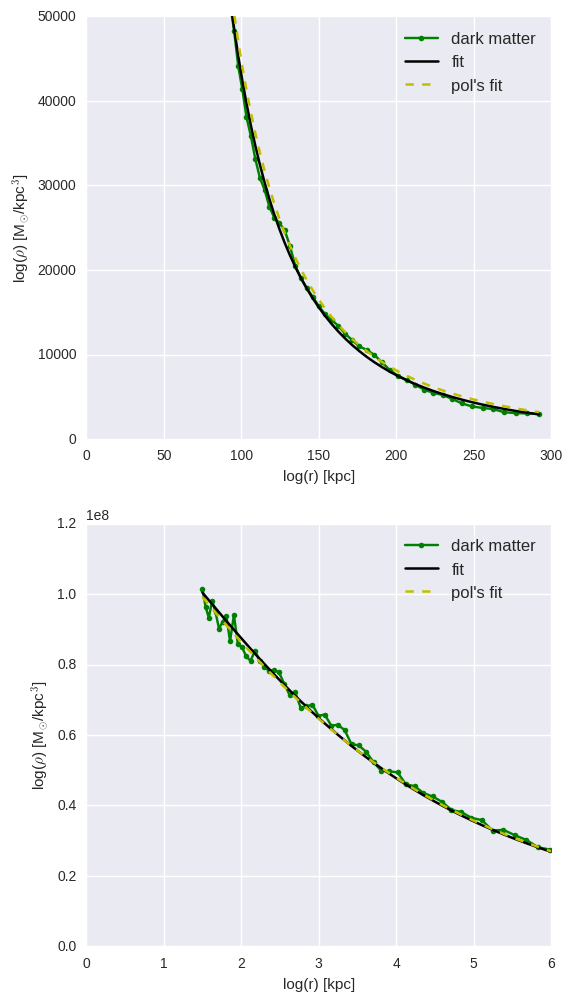

In [29]:
fig , [ax,ax1] = plt.subplots(2,1,figsize=[6,12])

ax.plot((r_p[0:-1]),(dens_dm),'go-',markersize=4, label="dark matter")
ax.plot((r_p[0:-1]),(abg_profile((r_p[0:-1]),mi.values['p_s'],mi.values['r_s'],mi.values['al'],mi.values['be'],mi.values['ga'])),
        'k-',linewidth=1.8,markersize=4, label="fit")


ax.plot((r_p[0:-1]),(abg_profile(r_p[0:-1],10**8.005,4.39,1.879,2.469,0.126
                            )),
        'y--',linewidth=1.8,markersize=4, label="pol's fit")

ax.set_ylim([0,5e4])
#ax.set_xlim([50,300])
y =[i for i in range(1,14)]
x_p03 =[np.log(R_P03) for i in range(1,14)]
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'log($\rho $) [M$_{\odot}$/kpc$^3$]')
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)



ax1.plot((r_p[0:-1]),(dens_dm),'go-',markersize=4, label="dark matter")
ax1.plot((r_p[0:-1]),(abg_profile((r_p[0:-1]),mi.values['p_s'],mi.values['r_s'],mi.values['al'],mi.values['be'],mi.values['ga'])),
        'k-',linewidth=1.8,markersize=4, label="fit")
ax1.plot((r_p[0:-1]),(abg_profile(r_p[0:-1],10**8.005,4.39,1.879,2.469,0.126
                            )),
        'y--',linewidth=1.8,markersize=4, label="pol's fit")
#ax1.set_ylim([0,5e4])
ax1.set_xlim([0,6])
y =[i for i in range(1,14)]
x_p03 =[np.log(R_P03) for i in range(1,14)]
ax1.set_xlabel("log(r) [kpc]")
ax1.set_ylabel(r'log($\rho $) [M$_{\odot}$/kpc$^3$]')
legend = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)



In [30]:
r_test  = np.logspace(-2,np.log10(260),300)
y =4*np.pi*(r_test**2)*abg_profile(r_test,mi.values['p_s'],mi.values['r_s'],mi.values['al'],mi.values['be'],mi.values['ga'])
y_pol =4*np.pi*(r_test**2)*abg_profile(r_test,1e8,4.39,1.879,2.469,0.126)

inte = np.trapz(y,x=r_test)
intePol = np.trapz(y_pol,x=r_test)
print "Simulation integrated mass      =   {0}".format(m_200)
print "my fit integrated mass          =   {0:.4e}".format(inte)
print "Pol's fit integrated mass       =   {0:.4e}".format(intePol)

Simulation integrated mass      =   1.53013804374e+12
my fit integrated mass          =   1.4690e+12
Pol's fit integrated mass       =   1.5001e+12


200 199


<Container object of 199 artists>

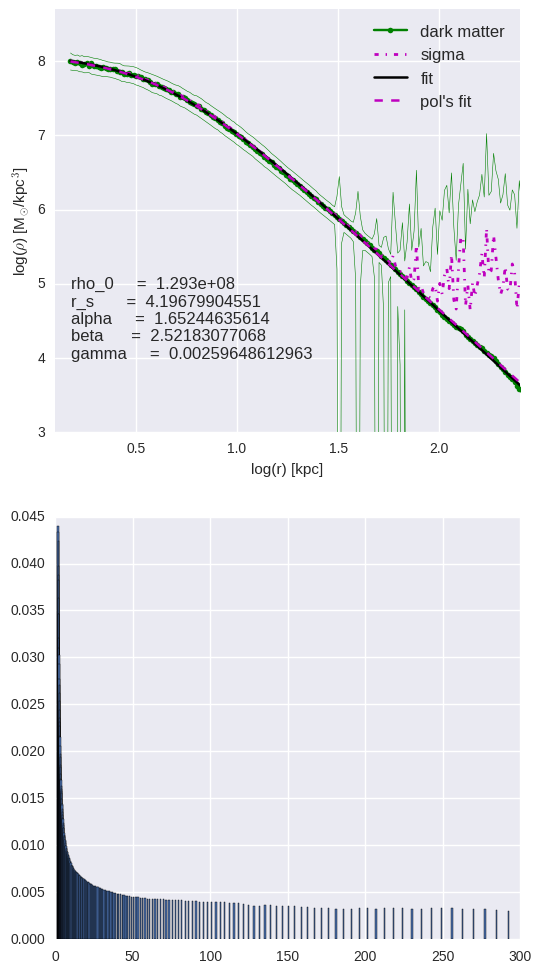

In [31]:
fig , [ax,ax1] = plt.subplots(2,1,figsize=[6,12])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_dm),'go-',markersize=4, label="dark matter")
#ax.plot(np.log10(r_p[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")


ax.plot(np.log10(r_p[0:-1]),np.log10(mean),'m-.',linewidth=2, label="sigma")
ax.plot(np.log10(r_p[0:-10]),np.log10(((mean-std)*((mean-std)>0)+0.0001)[:-9]),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
ax.plot(np.log10(r_p[0:-1]),np.log10(mean+std),'g-',linewidth=0.4)
ax.plot(np.log10(r_p[0:-1]),np.log10(abg_profile(r_p[0:-1],mi.values['p_s'],mi.values['r_s'],mi.values['al'],mi.values['be'],mi.values['ga'])),
        'k-',linewidth=1.8,markersize=4, label="fit")


ax.plot(np.log10(r_p[0:-1]),np.log10(abg_profile(r_p[0:-1],10**8.005,4.39,1.879,2.469,0.126
                            )),
        'm--',linewidth=1.8,markersize=4, label="pol's fit")

ax.set_ylim([3,8.7])
ax.set_xlim([0.1,2.4])
y =[i for i in range(1,14)]
x_p03 =[np.log(R_P03) for i in range(1,14)]
#ax.plot(x_p03,y)
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'log($\rho $) [M$_{\odot}$/kpc$^3$]')
ax.text(0.18,4,texto)
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)


print len(r_p), len(n) 
ax1.bar(r_p[0:-1],1/np.sqrt(n))

In [32]:
myhalo.rotate_galaxy()

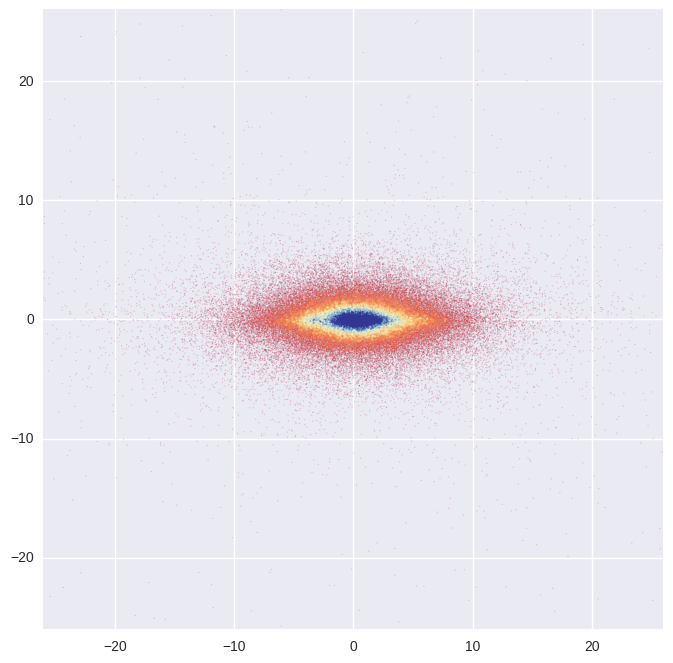

In [186]:
fig ,ax = plt.subplots(figsize=[8,8])
cm = plt.cm.get_cmap('RdYlBu')
ax.set_xlim([-26,26])
ax.set_ylim([-26,26])

co = (myhalo.st.pos3d[:,1]>-.1)&(myhalo.st.pos3d[:,1]<.1)
ax.scatter(myhalo.st.pos3d[co,0],myhalo.st.pos3d[co,2],c=rho_st[co], cmap=cm,vmin=1e7, vmax=9e8,lw=0, s=0.8,alpha=0.2)

In [157]:
myhalo.st.R = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)) -0.5

In [183]:
centro_dens = myhalo.st.pos3d[np.where(rho_st==rho_st.max())]
print centro_dens


[[-0.29340627 -0.1637933  -0.06005874]]


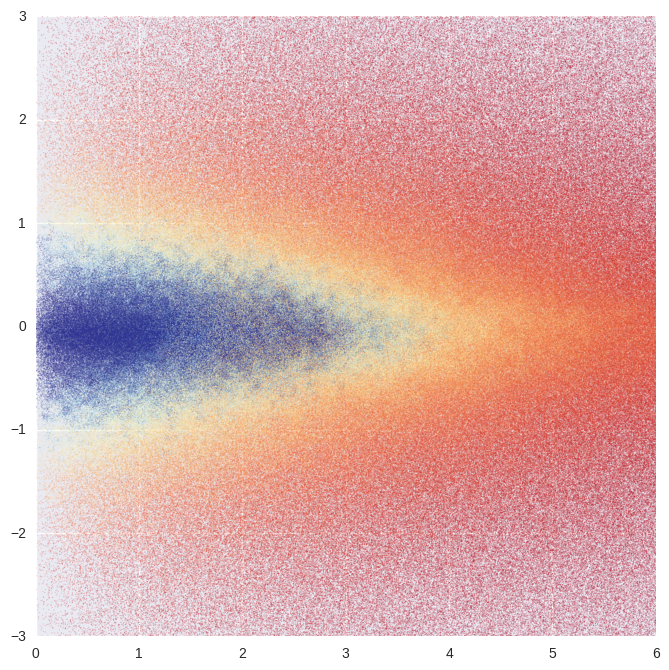

In [185]:
fig ,ax = plt.subplots(figsize=[8,8])
cm = plt.cm.get_cmap('RdYlBu')
ax.set_xlim([0,26])
ax.set_ylim([-26,26])
ax.set_xlim(0,6)
ax.set_ylim(-3,3)
co = np.where(myhalo.st.pos3d[:,1]>0.5)
ax.scatter(myhalo.st.R[co],myhalo.st.pos3d[co,2],c=rho_st[co], cmap=cm,vmin=1e7, vmax=9e8,lw=0, s=0.8,alpha=0.2)

# Baryons

In [176]:

xedges = np.logspace(-2,np.log10(15),30)
yedges = np.linspace(-7.5,7.5,30)
H, xedges, yedges = np.histogram2d(myhalo.st.R, myhalo.st.pos3d[:,2],
                                   bins=(xedges, yedges))
H =H.T

In [177]:
#print H 

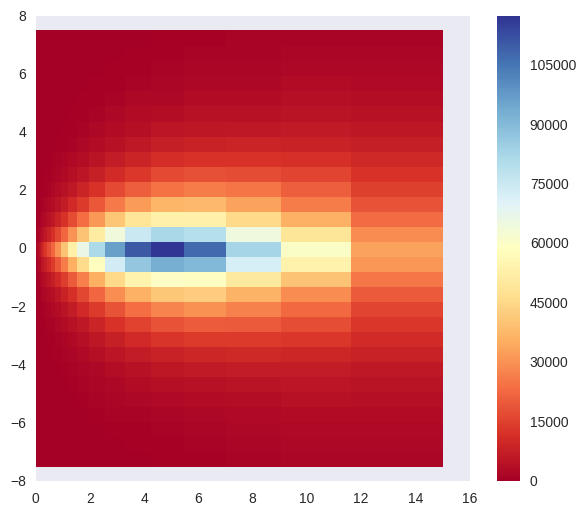

In [178]:
fig, ax = plt.subplots(figsize=[7,6])
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H,cmap=cm)
plt.colorbar(im)

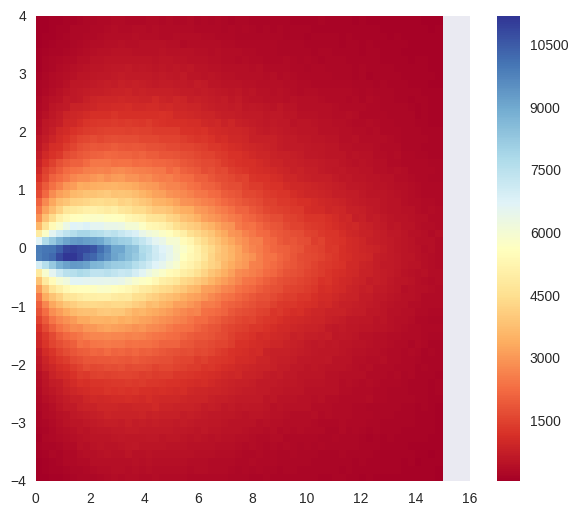

In [409]:
xedges = np.linspace(0,15,60)
#xedges = np.logspace(-2,np.log10(15),100)
yedges = np.linspace(-4,4,60)
H, xedges, yedges = np.histogram2d(myhalo.st.R, myhalo.st.pos3d[:,2],
                                   bins=(xedges, yedges))
H = H.T

fig, ax = plt.subplots(figsize=[7,6])
#ax.set_xlim(0,2)
#ax.set_ylim(-1,1)

X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H,cmap=cm)
plt.colorbar(im)

In [437]:
def stars(U,B_0,r0,al,r_cut,q,D_0,z_d,Rd):
    
    def McMBulge(r,z,B_0,r0,al,r_cut):
        x = np.sqrt(r**2 + (z/q)**2)
        bulge = B_0 * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = D_0 * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    r = U[:60]###BEWARE
    z = U[60:]
    R,Z = np.meshgrid(r,z)
    H = (McMBulge(R,Z,B_0,r0,al,r_cut)+McMDisc(R,Z,z_d,D_0,Rd))
    H = H.T
    return H.reshape(1,len(H)*len(H[0]))[0]
    


In [440]:
xedges = np.linspace(0,15,60)
yedges = np.linspace(-4,4,60)
U =np.concatenate((xedges,yedges))
stars(U,5844051361.6586685,0.595892,1.945,3.9998,0.3,391072701.31,0.5, 2.4954)
H.size
#H = H.reshape(1,len(H)*len(H[0]))[0]

3481

In [441]:
chi2log = probfit.Chi2Regression(stars,U, H)
iminuit.describe(chi2log)


['B_0', 'r0', 'al', 'r_cut', 'q', 'D_0', 'z_d', 'Rd']

In [442]:
m2d = iminuit.Minuit(chi2log,
                    B_0=0.9e7, limit_B_0=(1e7,1e11), error_B_0=.1,
                    r0=0.02,   limit_r0=(1e-9,6),       error_r0=0.0001,
                    al=0.6,    limit_al=(0.0,5),     error_al=0.0001,
                    r_cut=3,   limit_r_cut=(1,4),    error_r_cut=0.0001,
                    q = 0.5,   limit_q=(0.1,1.1),    error_q=0.0001,
                    D_0=3e9,   limit_D_0=(1e7,1e10),
                    z_d=0.08,  limit_z_d=(0.001,1),    error_z_d=0.0001,
                    Rd=1.5,    limit_Rd=(0,8)
                    )
my_fitarg = m2d.fitarg
print my_fitarg

{u'fix_D_0': False, u'error_r0': 0.0001, u'limit_D_0': (10000000.0, 10000000000.0), u'error_B_0': 0.1, u'fix_B_0': False, u'fix_r0': False, 'D_0': 3000000000.0, u'error_Rd': 1.0, 'al': 0.6, u'limit_Rd': (0, 8), u'fix_al': False, 'Rd': 1.5, u'fix_Rd': False, u'limit_q': (0.1, 1.1), u'fix_q': False, u'error_z_d': 0.0001, u'limit_z_d': (0.001, 1), 'r0': 0.02, 'r_cut': 3, u'limit_al': (0.0, 5), u'limit_r_cut': (1, 4), u'error_q': 0.0001, u'fix_r_cut': False, 'q': 0.5, 'z_d': 0.08, u'error_r_cut': 0.0001, 'B_0': 9000000.0, u'fix_z_d': False, u'limit_r0': (1e-09, 6), u'error_al': 0.0001, u'limit_B_0': (10000000.0, 100000000000.0), u'error_D_0': 1.0}


In [443]:
m2d.migrad()

TypeError: 'float' object has no attribute '__getitem__'

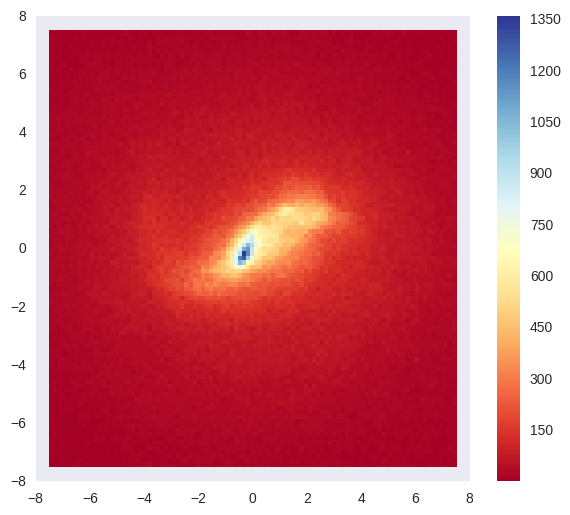

In [175]:
xedges = np.linspace(-7.5,7.5,100)
#xedges = np.logspace(-2,np.log10(15),100)
yedges = np.linspace(-7.5,7.5,100)
co = (myhalo.st.pos3d[:,2]>-0.2)&(myhalo.st.pos3d[:,2]<0.2)
H, xedges, yedges = np.histogram2d(myhalo.st.pos3d[co,0], myhalo.st.pos3d[co,1],
                                   bins=(xedges, yedges))
H = H.T

fig, ax = plt.subplots(figsize=[7,6])
#ax.set_xlim(0,2)
#ax.set_ylim(-1,1)

X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H,cmap=cm)
plt.colorbar(im)

In [358]:
r_p_st = np.logspace(-1,np.log10(15),300)
#r_p_st = np.linspace(0.1,30,800)
dens = np.array([])
m = np.array([])
v = np.array([])
n_bar = np.array([])
mean_st = np.array([])
std_st = np.array([])
n_bar=np.array([])
for i in range(len(r_p_st)-1):
    shell = np.where((myhalo.st.r > r_p_st[i])&(myhalo.st.r < r_p_st[i+1]))
    n_bar = np.append(n_bar,len(shell[0]))
    mass = np.sum(myhalo.st.mass[shell])
    mean_st = np.append(mean_st,np.mean(rho_st[shell]))
    std_st = np.append(std_st,np.std(rho_st[shell]))
    volume = 4.* np.pi * ((r_p_st[i+1]**3)-(r_p_st[i]**3)) / 3.
    dens = np.append(dens,mass/volume)
dens_st = dens

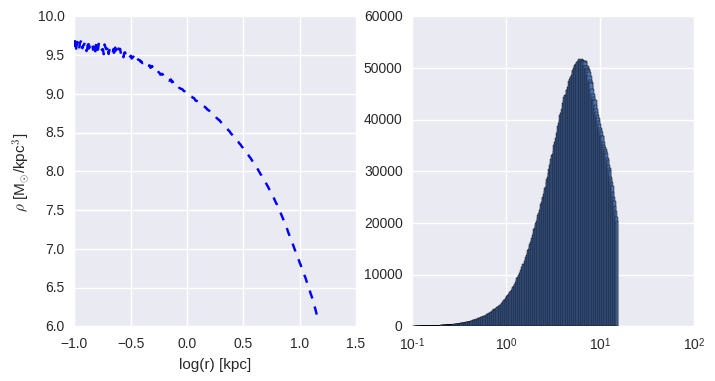

In [359]:
fig , [ax,ax1] = plt.subplots(1,2,figsize=[8,4])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'b--', label="data")
#ax.set_ylim([2,10.2])
#ax.set_xlim([-0.9,2.4])
ax1.bar(r_p_st[0:-1],n_bar)
ax1.set_xscale('log')
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [360]:
def stars(x,B_0,r0,al,r_cut,D_0,Rd):
    def McMBulge(x,B_0,r0,al,r_cut):
        bulge = B_0 * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,D_0,Rd):
        disc = D_0 * np.exp( - x / Rd )
        return disc
    x = 10**x
    return np.log10(McMBulge(x,B_0,r0,al,r_cut)+McMDisc(x,D_0,Rd))

    

In [361]:
#print r_p_st[15:-1]

In [362]:
chi2log = probfit.Chi2Regression(stars, np.log10(r_p_st[0:-1]),np.log10(dens_st[0:]))
iminuit.describe(chi2log)


['B_0', 'r0', 'al', 'r_cut', 'D_0', 'Rd']

In [18]:

m = iminuit.Minuit(chi2bar,
                    B_0=0.9e7, limit_B_0=(1e7,1e11), error_B_0=.1,
                    r0=0.02,     limit_r0=(1e-9,6),       error_r0=0.0001,
                    al=0.6,    limit_al=(0.0,5),     error_al=0.0001,
                    r_cut=3,   limit_r_cut=(1,4),    error_r_cut=0.0001,
                    D_0=3e9,     limit_D_0=(1e7,1e10),
                    Rd=1.5,    limit_Rd=(0,8),
                    pedantic=False, print_level=0
                   )
my_fitarg = m.fitarg
print my_fitarg

NameError: name 'chi2log' is not defined

In [364]:
m.migrad()

FCN = 0.202784908364 
 TOTAL NCALL = 616 
 NCALLS = 616 
 
 
 EDM = 0.000114895935478 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Parab Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 FIXED 
 
 
 
 1 
 B_0 
 5.84405e+09 
 4.35307e+09 
 0 
 0 
 10000000.0 
 1e+11 
 
 
 
 
 2 
 r0 
 0.595893 
 1.36445 
 0 
 0 
 1e-09 
 6.0 
 
 
 
 
 3 
 al 
 1.94548 
 3.4495 
 0 
 0 
 0.0 
 5.0 
 
 
 
 
 4 
 r_cut 
 3.99981 
 1.96788 
 0 
 0 
 1.0 
 4.0 
 
 
 
 
 5 
 D_0 
 3.91073e+08 
 6.25038e+08 
 0 
 0 
 10000000.0 
 10000000000.0 
 
 
 
 
 6 
 Rd 
 2.49541 
 0.934355 
 0 
 0 
 0.0 
 8.0 
 
 
 
 
 
 
 \begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Para Error & Error+ & Error- & Limit+ & Limit- & FIXED\\
\hline
1 & $B_{0}$ & 5.844e+09 & 4.353e+09 & & & 1.000e+07 & 1.000e+11 & \\
\hline
2 & r0 & 5.959e-01 & 1.364e+00 & & & 1.000e-09 & 6.000e+00 & \\
\hline
3 & al & 1.945e+00 & 3.449e+00 & & & 0.000e+00 & 5.000e+00 & \\
\hline
4 & $r_{cut}$ & 4.000e+00 & 1.968e+00 & & & 1.000e+00 & 4.000e+00 & \\
\hline
5 & $D_{0}$ & 3.911e+08 & 6.250e+08 & & & 1.000e+07 & 1.000e+10 & \\
\hline
6 & Rd & 2.495e+00 & 9.344e-01 & & & 0.000e+00 & 8.000e+00 & \\
\hline
\end{tabular}

({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 1.0, 'edm': 0.0001148959354781094, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 0.202784908364403, 'nfcn': 616},
 [{'is_const': False, 'name': 'B_0', 'has_limits': True, 'value': 5844051361.6586685, 'number': 0, 'has_lower_limit': True, 'upper_limit': 100000000000.0, 'lower_limit': 10000000.0, 'has_upper_limit': True, 'error': 4353067549.545262, 'is_fixed': False},
  {'is_const': False, 'name': 'r0', 'has_limits': True, 'value': 0.5958927512961348, 'number': 1, 'has_lower_limit': True, 'upper_limit': 6.0, 'lower_limit': 1e-09, 'has_upper_limit': True, 'error': 1.364452202558716, 'is_fixed': False},
  {'is_const': False, 'name': 'al', 'has_limits': True, 'value': 1.9454842656641622, 'number': 2, 'has_lower_limit': True, 'upper_limit': 5.0, 'lower_limit': 0.0, 'has_upper_limit': 

In [365]:
print m.values

{'r0': 0.5958927512961348, 'r_cut': 3.9998105255669225, 'D_0': 391072701.3148485, 'al': 1.9454842656641622, 'Rd': 2.49540938440638, 'B_0': 5844051361.6586685}


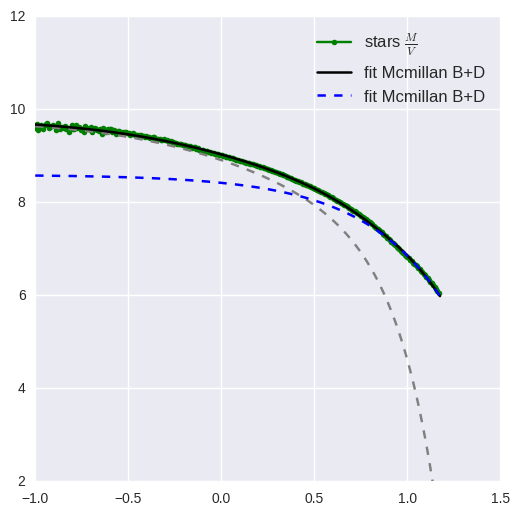

In [366]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'go-',markersize=4, label=r'stars $\frac{M}{V}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")
#ax.scatter(np.log10(myhalo.st.r), np.log10(rho_st),s=1,linewidths=0,alpha=0.5)

#ax.set_xlim([-1,2])
ax.set_ylim([2,12])

#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st),'m-.',linewidth=2, label=r'mean $\rho_{local}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st-std_st),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p_st[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st+std_st),'g-',linewidth=0.4)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st_st[0:-1],params[0],params[1],params[2],params[3],params[4],params[5])),
#        'k-',linewidth=1.8,markersize=4, label="fit")
ax.plot(np.log10(r_p_st),np.log10(McMBulge(r_p_st,m.values['B_0'],m.values['r0'],
                                           m.values['al'],m.values['r_cut'])),'gray', ls='--')
sumation = (McMBulge(r_p_st,m.values['B_0'],m.values['r0'],m.values['al'],m.values['r_cut'])) +\
           (McMDisc(r_p_st,m.values['D_0'],m.values['Rd']))
ax.plot(np.log10(r_p_st),np.log10(sumation),
        'k-',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

ax.plot(np.log10(r_p_st),np.log10(McMDisc(r_p_st,m.values['D_0'],m.values['Rd'])),
        'b--',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

In [166]:
# B_0,D_0,r0,al,r_cut,Rd
# a,b,M,ah,Mh
mins = np.array([0, 0, 7e9,  0,4e8])
maxs = np.array([5, 0.6, 7e11,  1, 9e10])
fitabg =mia_bar_fit(mins=mins, maxs=maxs)

params,chi2mia = fitabg.bestfit(r_p_st[0:-1],dens_st,n_bar)
texto = "a_mia        =  {0}\nb_mia        =  {1}\nMmia         =  {2:.6e}\na_h          =  {3}\nM_h          =  {4:.6e} \nchi2         = {5} \nReducedChi2  = {6}".format(params[0],params[1],params[2],params[3],params[4],chi2mia, chi2mia / (len(dens_st-len(params))))

print texto


a_mia        =  2.45832699369
b_mia        =  0.456956408457
Mmia         =  1.511023e+10
a_h          =  0.662066129301
M_h          =  2.059633e+10 
chi2         = 0.545560178042 
ReducedChi2  = 0.0188124199325


## McMillan fit

In [29]:
# B_0,D_0,r0,al,r_cut,Rd
# a,b,M,ah,Mh
mins = np.array([1e8 , 1e8 , 0,  0, 0 ,1.1])
maxs = np.array([1e11, 1e11, 5,  6, 3 ,3])
fitmc = Mcmillan_bar_fit(mins=mins, maxs=maxs)

paramsMc,chi2mc = fitmc.bestfit(r_p_st[0:-1],dens_st,n_bar)
texto = "B_0        =  {0:.4e}\nD_0        =  {1:.4e}\nr0         =  {2}\nalpha      =  {3}\nr_cut      =  {4} \nrd         =  {5} \nchi2       =  {6} \nReducedchi2=  {7}".format(paramsMc[0],paramsMc[1],paramsMc[2],paramsMc[3],paramsMc[4],paramsMc[5],chi2mc,chi2mc/(len(dens_st)-len(paramsMc)))

print texto


NameError: name 'Mcmillan_bar_fit' is not defined

NameError: name 'mia_H' is not defined

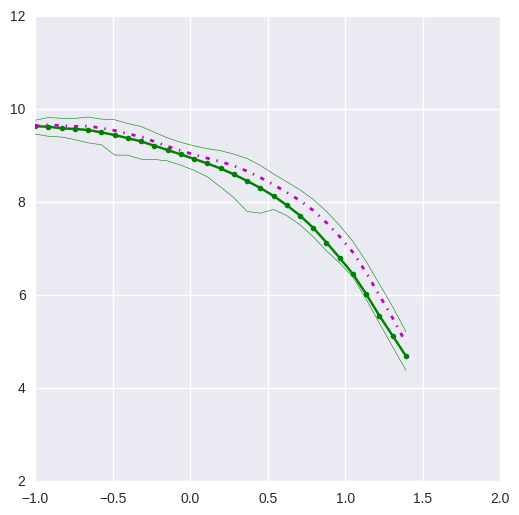

In [30]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'go-',markersize=4, label=r'stars $\frac{M}{V}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")
#ax.scatter(np.log10(myhalo.st.r), np.log10(rho_st),s=1,linewidths=0,alpha=0.5)

ax.set_xlim([-1,2])
ax.set_ylim([2,12])

ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st),'m-.',linewidth=2, label=r'mean $\rho_{local}$')
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st-std_st),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p_st[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st+std_st),'g-',linewidth=0.4)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st_st[0:-1],params[0],params[1],params[2],params[3],params[4],params[5])),
#        'k-',linewidth=1.8,markersize=4, label="fit")
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mia_H(r_p_st[0:-1],params[0],params[1],params[2],params[3],params[4])),
        'k-',linewidth=1.8,markersize=4, label="fit Mia+H")

ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st[0:-1],paramsMc[0],paramsMc[1],paramsMc[2],paramsMc[3],paramsMc[4],paramsMc[5])),
        'b-',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

rerun this 

In [199]:
def McMBulge(x,B_0,r0,al,r_cut):
    bulge = B_0 * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
    return bulge

def McMDisc(x,D_0,Rd):
    disc = D_0 * np.exp( - x / Rd )
    return disc


class Mcmillan_disc_fit:
    """
    performs a fit of a alpha beta gamma density profile fit
    """
    def __init__(self,**var):
        self.pos_min = var.get('mins',np.array([2e8,0.,-1.,-1.]))
        self.pos_max = var.get('maxs',np.array([2e10,10.,5.,5.]))

    def bestfit(self,x,y,n):
        def McMDisc(x,D_0,Rd):
            disc = D_0 * np.exp( - x / Rd )
            return disc

        self.ndim = 2
        func = McMDisc
        yerr = 1 / np.sqrt(n)
        # Now, let's setup some parameters that define the MCMC
        self.nwalkers = 800

        # Initialize the chai# Choice 1: chai1uniformly distributed in the range of the parameters
        self.psize = self.pos_max - self.pos_min
        self.pos = [self.pos_min + self.psize*np.random.rand(self.ndim) for i in range(self.nwalkers)]
        # As prior, we assume an 'uniform' prior (i.e. constant prob. density)
        def lnprior(theta):
            D_0,rd = theta
            if self.pos_min[0] < D_0 < self.pos_max[0] and  \
                          self.pos_min[1] < rd < self.pos_max[1]:
                            return 0.0
            return -np.inf

        def lnlike(theta, x, y,yerr):
            D_0,rd = theta
            alpha = 1.
            model = func(x,D_0,rd)
            return -0.5*(np.sum( ((y-model)/yerr)**2. ))

        # As likelihood, we assume the chi-square. Note: we do not even need to normalize it.

        def lnprob(theta, x, y, yerr):
            lp = lnprior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + lnlike(theta, x, y, yerr)

        sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim,
                                lnprob, args=(x, y, yerr))
        sampler.reset()
        self.pos, self.prob, self.state  = sampler.run_mcmc(self.pos, 300)
        sampler.reset()
        self.pos, self.prob, self.state  = sampler.run_mcmc(self.pos, 700)
        samples = sampler.flatchain
        samples.shape
        sam=samples#[-600:]
        self.expected = np.array([func(x,i[0],i[1]) for i in sam ])
        self.observed = np.array([y for i in sam])
        chi_tmp = ((np.log10(self.observed)-np.log10(self.expected))**2)/np.log10(self.expected)
        chi2 = np.array([np.sum(i) for i in chi_tmp])
        chi2 = chi2[np.where(chi2>0)]
        self.params = sam[np.where(chi2==np.nanmin(chi2))[0][0]]
        return self.params, np.nanmin(chi2)


class Mcmillan_bulge_fit:
    """
    performs a fit of a alpha beta gamma density profile fit
    """
    def __init__(self,**var):
        self.pos_min = var.get('mins',np.array([2e8,0.,-1.,-1.]))
        self.pos_max = var.get('maxs',np.array([2e10,10.,5.,5.]))

    def bestfit(self,x,y,n):
        def McMBulge(x,B_0,r0,al,r_cut):
            bulge = B_0 * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
            return bulge

        self.ndim = 4.
        func = McMBulge
        yerr = 1 / np.sqrt(n)
        # Now, let's setup some parameters that define the MCMC
        self.nwalkers = 800
        # Initialize the chain
        # Choice 1: chain uniformly distributed in the range of the parameters
        self.psize = self.pos_max - self.pos_min
        self.pos = [self.pos_min + self.psize*np.random.rand(self.ndim) for i in range(self.nwalkers)]
        # As prior, we assume an 'uniform' prior (i.e. constant prob. density)
        def lnprior(theta):
            B_0,r0,al,r_cut = theta
            if self.pos_min[0] < B_0 < self.pos_max[0] and  \
                     self.pos_min[1] < r0 < self.pos_max[1] and \
                        self.pos_min[2] < al < self.pos_max[2] and \
                          self.pos_min[3] < r_cut < self.pos_max[3]:
                            return 0.0
            return -np.inf

        def lnlike(theta, x, y,yerr):
            B_0,r0,al,r_cut = theta
            alpha = 1.
            model = func(x,B_0,r0,al,r_cut)
            return -0.5*(np.sum( ((y-model)/yerr)**2. ))

        # As likelihood, we assume the chi-square. Note: we do not even need to normalize it.

        def lnprob(theta, x, y, yerr):
            lp = lnprior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + lnlike(theta, x, y, yerr)

        sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim,
                                lnprob, args=(x, y, yerr))
        sampler.reset()
        self.pos, self.prob, self.state  = sampler.run_mcmc(self.pos, 300)
        sampler.reset()
        self.pos, self.prob, self.state  = sampler.run_mcmc(self.pos, 700)
        samples = sampler.flatchain
        samples.shape
        sam=samples#[-600:]
        self.expected = np.array([func(x,i[0],i[1],i[2],i[3]) for i in sam ])
        self.observed = np.array([y for i in sam])
        chi_tmp = ((np.log10(self.observed)-np.log10(self.expected))**2)/np.log10(self.expected)
        chi2 = np.array([np.sum(i) for i in chi_tmp])
        chi2 = chi2[np.where(chi2>0)]
        self.params = sam[np.where(chi2==np.nanmin(chi2))[0][0]]
        return self.params, np.nanmin(chi2)


In [78]:
# B_0,r0,al,r_cut
dens_bulge = dens_st[np.where(r_p_st < 5)]
n_bulge = dens_st[np.where(r_p_st < 5)]
r_bulge = r_p_st[np.where(r_p_st < 5)]

mins = np.array([1e8 , 0,  0, 2])
maxs = np.array([1e11, 5,  6, 3])
fitmc = Mcmillan_bulge_fit(mins=mins, maxs=maxs)

parbulge,chi2bg = fitmc.bestfit(r_bulge,dens_bulge,n_bulge)
texto = "B_0        =  {0}\nr0        =  {1}\nalpha      =  {2}\nr_cut      =  {3} \nchi2       =  {4} \nReducedchi2=  {5}".format(parbulge[0],parbulge[1],parbulge[2],parbulge[3],chi2bg,chi2bg/(len(dens_bulge)-len(parbulge)))

print texto

B_0        =  15411470090.6
r0        =  0.0244647498965
alpha      =  0.688007875847
r_cut      =  2.96482094031 
chi2       =  0.0105738796167 
Reducedchi2=  0.000660867476045


In [87]:
dens_disc = dens_st[np.where(r_p_st[:-1] > 3)]
n_disc = dens_st[np.where(r_p_st[:-1] > 3)]
r_disc = r_p_st[np.where(r_p_st[:-1] > 3)]

mins = np.array([1e8 , 0])
maxs = np.array([1e11, 8])
fitmc = Mcmillan_disc_fit(mins=mins, maxs=maxs)

pardisc,chi2ds = fitmc.bestfit(r_disc,dens_disc,n_disc)
texto = "D_0        =  {0:.3e}\nrd        =  {1} \nchi2       =  {2} \nReducedchi2=  {2}".format(pardisc[0],pardisc[1],chi2ds,chi2ds/(len(dens_disc)-len(pardisc)))

print texto

D_0        =  1.045e+09
rd        =  1.69501421107 
chi2       =  0.00929452885817 
Reducedchi2=  0.00929452885817


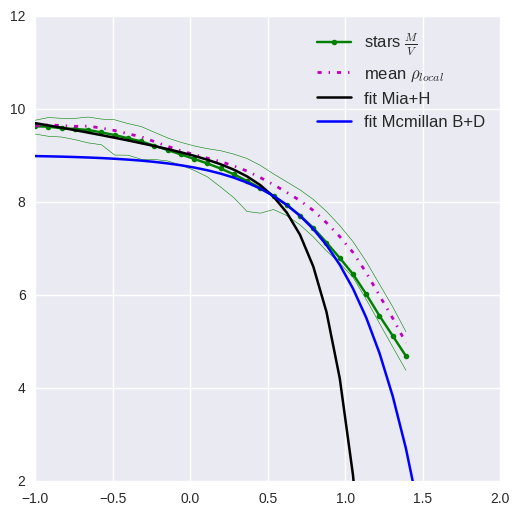

In [91]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'go-',markersize=4, label=r'stars $\frac{M}{V}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")
#ax.scatter(np.log10(myhalo.st.r), np.log10(rho_st),s=1,linewidths=0,alpha=0.5)

ax.set_xlim([-1,2])
ax.set_ylim([2,12])

ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st),'m-.',linewidth=2, label=r'mean $\rho_{local}$')
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st-std_st),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p_st[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st+std_st),'g-',linewidth=0.4)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st_st[0:-1],params[0],params[1],params[2],params[3],params[4],params[5])),
#        'k-',linewidth=1.8,markersize=4, label="fit")
ax.plot(np.log10(r_p_st),np.log10(McMBulge(r_p_st,parbulge[0],parbulge[1],parbulge[2],parbulge[3])),
        'k-',linewidth=1.8,markersize=4, label="fit Mia+H")

ax.plot(np.log10(r_p_st),np.log10(McMDisc(r_p_st,pardisc[0],pardisc[1])),
        'b-',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

In [60]:
print len(r_bulge),len()

20


mia fit here

In [32]:
def mia_H(x,a,b,M,ah,Mh):
    z = 0
    sq = np.sqrt(z**2+b**2)
    mia =  M * (a+(3*sq*(a+sq)**2)) / (4*np.pi*((x**2 +(a+sq)**2)**2.5)*(z**2+b**2)**1.5)
    H = Mh / 2 / np.pi / (ah * (x + ah)**3 ) 
    return mia + H



class mia_bar_fit:
    """
    performs a fit of a alpha beta gamma density profile fit
    """
    def __init__(self,**var):
        self.pos_min = var.get('mins',np.array([2e8,0.,-1.,-1.,-1.,-1]))
        self.pos_max = var.get('maxs',np.array([2e10,10.,5.,5.,5.,7]))

    def bestfit(self,x,y,n):
        def mia_H(x,a,b,M,ah,Mh):
            z = 0
            sq = np.sqrt(z**2+b**2)
            mia =  M * (a+(3*sq*(a+sq)**2)) / (4*np.pi*((x**2 +(a+sq)**2)**2.5)*(z**2+b**2)**1.5)
            H = Mh / 2 / np.pi / (ah * (x + ah)**3 ) 
            return mia + H

        self.ndim = 5
        func = mia_H
        yerr = 1 / np.sqrt(n)
        # Now, let's setup some parameters that define the MCMC
        self.nwalkers = 600
        # Initialize the chain
        # Choice 1: chain uniformly distributed in the range of the parameters
        self.psize = self.pos_max - self.pos_min
        self.pos = [self.pos_min + self.psize*np.random.rand(self.ndim) for i in range(self.nwalkers)]
        # As prior, we assume an 'uniform' prior (i.e. constant prob. density)
        def lnprior(theta):
            B_0,D_0,r0,al,Rd = theta
            if self.pos_min[0] < B_0 < self.pos_max[0] and  \
                   self.pos_min[1] < D_0 < self.pos_max[1] and  \
                     self.pos_min[2] < r0 < self.pos_max[2] and \
                        self.pos_min[3] < al < self.pos_max[3] and \
                          self.pos_min[4] < Rd < self.pos_max[4]:
                            return 0.0
            return -np.inf

        def lnlike(theta, x, y,yerr):
            B_0,D_0,r0,al,Rd = theta
            alpha = 1.
            model = func(x,B_0,D_0,r0,al,Rd)
            return -0.5*(np.sum( ((y-model)/yerr)**2. ))

        # As likelihood, we assume the chi-square. Note: we do not even need to normalize it.

        def lnprob(theta, x, y, yerr):
            lp = lnprior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + lnlike(theta, x, y, yerr)

        sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim,
                                lnprob, args=(x, y, yerr))
        sampler.reset()
        self.pos, self.prob, self.state  = sampler.run_mcmc(self.pos, 300)
        sampler.reset()
        self.pos, self.prob, self.state  = sampler.run_mcmc(self.pos, 700)
        samples = sampler.flatchain
        samples.shape
        sam=samples[-400:]
        self.expected = np.array([func(x,i[0],i[1],i[2],i[3],i[4]) for i in sam ])
        self.observed = np.array([y for i in sam])
        chi_tmp = ((np.log10(self.observed)-np.log10(self.expected))**2)/np.log10(self.expected)
        chi2 = np.array([np.sum(i) for i in chi_tmp])
        chi2 = chi2[np.where(chi2>0)]
        self.params = sam[np.where(chi2==np.nanmin(chi2))[0][0]]
        return self.params, np.nanmin(chi2)

In [51]:
a = np.array([1, 2, 3])
b = np.array([2, 3, 4,8])
np.concatenate((a, b),axis=0)

array([1, 2, 3, 2, 3, 4, 8])

In [53]:
### radius ###
#r_baryons = np.array([]).reshape(0,1)
r_baryons = np.concatenate((myhalo.gs.r,myhalo.st.r),axis=0)
### dens ###
#rho_baryons = np.concatenate((myhalo.gs.rho,rhoint _baryons),axis=0)
### mass ###
mass_baryons = np.concatenate((myhalo.gs.mass,myhalo.st.mass),axis=0)

In [55]:
positions = np.array([])

r_p_st = np.logspace(-1,np.log10(30),30)
dens = np.array([])
m = np.array([])
v = np.array([])
n_bar = np.array([])
mean_st = np.array([])
std_st = np.array([])
n_bar=np.array([])
for i in range(len(r_p_st)-1):
    shell = np.where((r_baryons > r_p_st[i])&(r_baryons < r_p_st[i+1]))
    n_bar = np.append(n_bar,len(shell[0]))
    mass = np.sum(mass_baryons[shell])
    #mean_st = np.append(mean_st,np.mean(rho_baryons[shell]))
    #std_st = np.append(std_st,np.std(rho_baryons[shell]))
    volume = 4.* np.pi * ((r_p_st[i+1]**3)-(r_p_st[i]**3)) / 3.
    dens = np.append(dens,mass/volume)
dens_st = dens

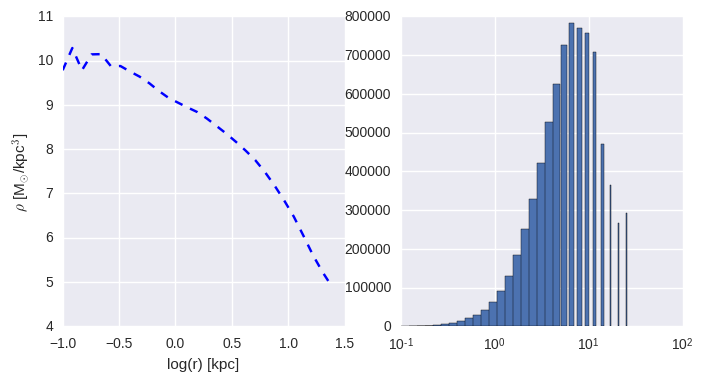

In [56]:
fig , [ax,ax1] = plt.subplots(1,2,figsize=[8,4])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'b--', label="data")
#ax.set_ylim([2,10.2])
#ax.set_xlim([-0.9,2.4])
ax1.bar(r_p_st[0:-1],n_bar)
ax1.set_xscale('log')
ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [57]:
with open("HaloA-profile-baryons.txt", "w") as text_file:
    text_file.write("# r (kpc), rho (Msun.kpc^-3)\n")
    for i in range(len(r_p_st[0:-1])):
        text_file.write("{0:.4e} {1:.4e} \n".format(r_p_st[i],dens_st[i]))



In [37]:
# B_0,D_0,r0,al,r_cut,Rd
# a,b,M,ah,Mh
mins = np.array([0, 0, 7e9,  0,4e8])
maxs = np.array([5, 0.6, 7e11,  1, 9e10])
fitabg =mia_bar_fit(mins=mins, maxs=maxs)

params,chi2mia = fitabg.bestfit(r_p_st[0:-1],dens_st,n_bar)
texto = "a_mia        =  {0}\nb_mia        =  {1}\nMmia         =  {2:.6e}\na_h          =  {3}\nM_h          =  {4:.6e} \nchi2         = {5} \nReducedChi2  = {6}".format(params[0],params[1],params[2],params[3],params[4],chi2mia, chi2mia / (len(dens_st-len(params))))

print texto

a_mia        =  4.99999998989
b_mia        =  0.59999999567
Mmia         =  4.402978e+10
a_h          =  0.537626899285
M_h          =  1.450109e+10 
chi2         = 0.290761534377 
ReducedChi2  = 0.0100262598061


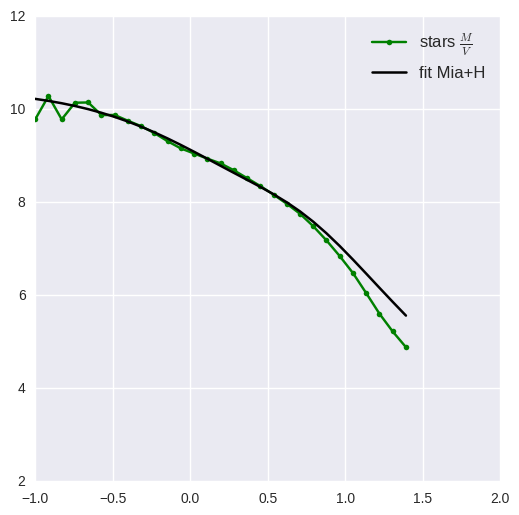

In [38]:
fig , ax = plt.subplots(figsize=[6,6])
ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'go-',markersize=4, label=r'stars $\frac{M}{V}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")
#ax.scatter(np.log10(myhalo.st.r), np.log10(rho_st),s=1,linewidths=0,alpha=0.5)

ax.set_xlim([-1,2])
ax.set_ylim([2,12])

#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st),'m-.',linewidth=2, label=r'mean $\rho_{local}$')
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st-std_st),'g-',linewidth=0.4)
#ax.fill_between(np.log10(r_p_st[0:-1]),np.log10(mean+std),np.log10(mean_),facecolor='g',alpha=0.5)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mean_st+std_st),'g-',linewidth=0.4)
#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st_st[0:-1],params[0],params[1],params[2],params[3],params[4],params[5])),
#        'k-',linewidth=1.8,markersize=4, label="fit")
ax.plot(np.log10(r_p_st[0:-1]),np.log10(mia_H(r_p_st[0:-1],params[0],params[1],params[2],params[3],params[4])),
        'k-',linewidth=1.8,markersize=4, label="fit Mia+H")

#ax.plot(np.log10(r_p_st[0:-1]),np.log10(mcmillan(r_p_st[0:-1],paramsMc[0],paramsMc[1],paramsMc[2],paramsMc[3],paramsMc[4],paramsMc[5])),
#       'b-',linewidth=1.8,markersize=4, label="fit Mcmillan B+D")

legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=12)

# Velocity distributions

In [149]:
fl = open("/home/arturo/Downloads/f_numerical_halo_A_mass_model_8.0kpc_velocity.txt")
v_num = np.array([])
fdvnum = np.array([])

for ln in fl:
    if ln[0][0]=='#':
        continue
    row = ln.split(' ')
    v_num = np.append(v_num,float(row[0]))
    fdvnum = np.append(fdvnum,float(row[1]))
    

before  7143580
after  57549
min = 6.88470602036, max = 787.008972168
57549


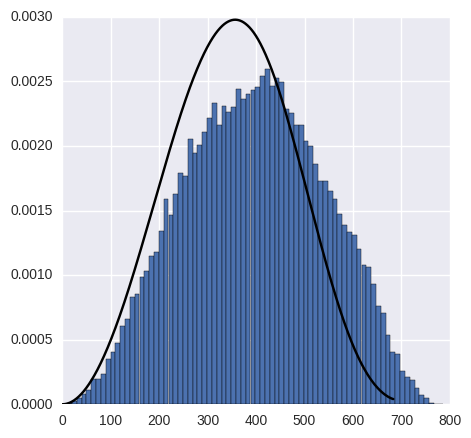

In [153]:
print "before ", len(myhalo.dm.vel3d)
shell8kpc = (myhalo.dm.r > 7.5) & (myhalo.dm.r < 8.5)
vel3d_8kpc = myhalo.dm.vel3d[shell8kpc]
tot = len(vel3d_8kpc)
print "after ", len(vel3d_8kpc)
speed_8kpc = np.sqrt(vel3d_8kpc[:,0]**2 + vel3d_8kpc[:,1]**2 +vel3d_8kpc[:,2]**2)
print "min = {0}, max = {1}".format(speed_8kpc.min(),speed_8kpc.max())
bin_num = 80
bins = np.linspace(0, speed_8kpc.max(),bin_num)
w = speed_8kpc.max() / bin_num 
fdv = np.histogram(speed_8kpc,bins=bins,normed=1)
fig, ax = plt.subplots(figsize=[5,5])
ax.bar(fdv[1][0:-1],fdv[0],width=w)
ax.plot(v_num,fdvnum,'k')
print tot
#ax.set_xlabel('|$\vec{v}$|',fontsize=20)
#ax.set_ylabel('f(|$\vec{v}$|)',fontsize=20)



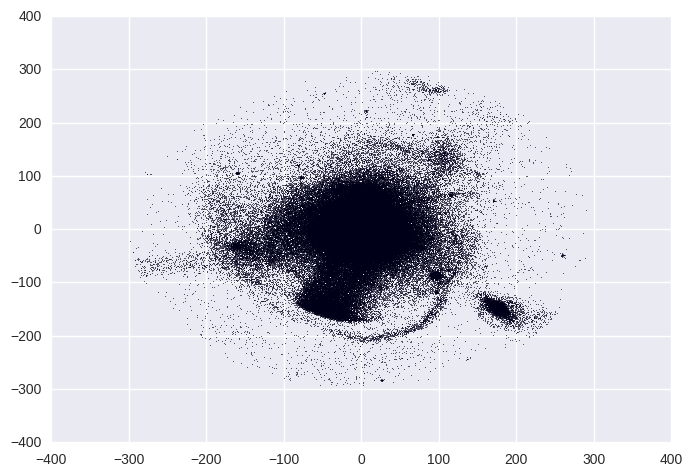

In [16]:
fig,ax = plt.subplots()
ax.scatter(myhalo.st.pos3d[:,0],myhalo.st.pos3d[:,2],s=0.1)

In [17]:
def beta_shell(r,r2):
    shell_condition = (myhalo.dm.r > r)&(myhalo.dm.r < r2)
    vphi_shell = myhalo.dm.vphi[shell_condition]
    
    vr_shell = myhalo.dm.vr[shell_condition]
    sigmaT_shell = np.std(vphi_shell)
    sigmar_shell = np.std(vr_shell)
    return 1-(sigmaT_shell/sigmar_shell)

get_beta_shell = np.vectorize(beta_shell)
    

In [20]:
r_sample = np.linspace(0,300,60)
r1 = r_sample[:-1]
r2 = r_sample[1:]
beta_in_shell = get_beta_shell(r1,r2)

cen = r1 +(r2-r1)/ 2


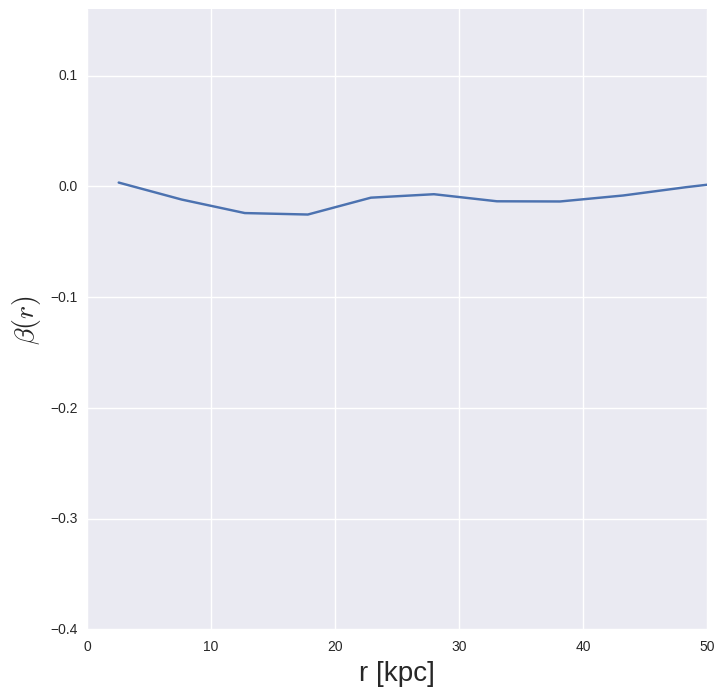

In [21]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([0,50])
ax.plot(cen,beta_in_shell)
ax.set_ylabel(r'$\beta(r)$',fontsize=20)
ax.set_xlabel(r'r [kpc]',fontsize=20)
ax.set_ylim([-0.4,0.16])
y = [i for i in np.arange(-0.2,0.18,0.01)]
x = [172 for i in y]
#ax.set_xscale('log')
ax.plot(x,y,'k--', alpha=0.5)
#ax.text(162,0.01,r'R$_{200}$',fontsize=20)
#ax.text(20,0.1,r'$\beta(r) = 1 - \frac{\sigma_T}{\sigma_r}$',fontsize=25)

In [ ]:
myhalo.dm.vel3d = myhalo.dm.vel3d + average

In [12]:
#myhalo.center_shift(-centroide)
#pos = myhalo.dm.pos3d
#myhalo.dm.r = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))
#r_baryons = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
#myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))

In [23]:
mean_= (mean-std)*(((mean-std)>0))
mean_[-9]=0.0001
mean_

array([  3.88556520e+08,   3.43511608e+08,   3.45881896e+08,
         3.08148032e+08,   2.98571624e+08,   2.91072816e+08,
         2.79404464e+08,   2.42528688e+08,   2.19849232e+08,
         1.89118936e+08,   1.60813576e+08,   1.24682960e+08,
         8.85305800e+07,   5.81526140e+07,   3.46797080e+07,
         1.96198960e+07,   1.06931690e+07,   5.73106250e+06,
         3.07652838e+06,   4.68364875e+05,   1.00000000e-04,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00])

In [ ]:
#myhalo.center_shift(-centroide)
#pos = myhalo.st.pos3d
#myhalo.st.r = np.sqrt((pos[:,0]**2)+(pos[:,1]**2)+(pos[:,2]**2))

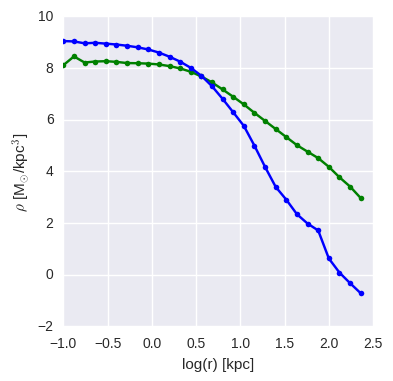

In [71]:
fig , ax = plt.subplots(figsize=[4,4])
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_dm),'go-',markersize=4, label="dark matter")
ax.plot(np.log10(r_p[0:-1]),np.log10(dens_st),'bo-',markersize=4, label="stars")

#ax.set_ylim([2,10.2])
#ax.set_xlim([-1.1,2.4])

ax.set_xlabel("log(r) [kpc]")
ax.set_ylabel(r'$\rho $ [M$_{\odot}$/kpc$^3$]')
#ax.plot(np.log10(x_P03),y,'k-.')

In [ ]:
np.log10(1956566876)

In [5]:
myhalo.r_virial(600)

| r_200 = 172.842710452
---- taking particles inside 2.5 * r200
%%flag dm
%%flag st
%%flag gs
| number of praticles inside 2.5 * r200 
| dm mass       =  8.05216190464e+11 M_sun
| p_dm_200      =  3488602 particles
| stellar mass  =  79916277760.0 M_sun
| p_st_200      =  2161812 psrticles
| gas mass      =  79578636288.0 M_sun
| p_gs_200      =  7828605 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |15,0,0|
| D =|0,12,0|
|    |0,0,1|


In [9]:
myhalo.save_galaxy("snap1.g2","gadget2","halo")

1
1


In [ ]:
myhalo.save_galaxy("snap1st.g2","gadget2","stars")

In [17]:
myhalo.save_galaxy("snap1gs.g2","gadget2","gas")

1
1


In [15]:
with open("Halo-C-Stars-pos-rho.txt", "w") as text_file:
    text_file.write("# Stars position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.st.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.st.pos3d[i,0],
                                                           myhalo.st.pos3d[i,1],
                                                           myhalo.st.pos3d[i,2],
                                                           rho_st[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.st.pos3d)))

In [16]:
with open("Halo-C-Gas-pos-rho.txt", "w") as text_file:
    text_file.write("# Gas position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.gs.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.gs.pos3d[i,0],
                                                           myhalo.gs.pos3d[i,1],
                                                           myhalo.gs.pos3d[i,2],
                                                           myhalo.gs.rho[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.gs.pos3d)))

In [17]:
with open("Halo-C-DarkMatter-pos-rho.txt", "w") as text_file:
    text_file.write("# DM position and density of HALO C\n# R200 = 172 \n# format:\n#  x[kpc]     y[kpc]     z[kpc]     rho[Msun/Kpc^3] \n")
    for i in range(len(myhalo.dm.r)):
        text_file.write("{0:.4e} {1:.4e} {2:.4e} {3:.4e} \n".format(myhalo.dm.pos3d[i,0],
                                                           myhalo.dm.pos3d[i,1],
                                                           myhalo.dm.pos3d[i,2],
                                                           rho_dm[i]
                                                          ))
    text_file.write("# TOTAL = {0}".format(len(myhalo.dm.pos3d)))

In [17]:
with open("Halo-B-Anisotropy.txt", "w") as text_file:
    text_file.write("# Halo beta paramiter of HALO B\n# R200 = 172 kpc \n# format:\n#  r [kpc] beta(r) \n")
    for i in range(len(r_sample)): 
        text_file.write("{0:.4e} {1:.4e} \n".format(r_sample[i], beta_in_shell[i]))
    text_file.write("# TOTAL = {0}".format(len(r_sample)))